<a href="https://colab.research.google.com/github/dgadela/ML_HandsOn/blob/master/CancerAnalysisDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projecting 30-dimensional data to 2D
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 569 samples in 0.003s...
[t-SNE] Computed neighbors for 569 samples in 0.053s...
[t-SNE] Computed conditional probabilities for sample 569 / 569
[t-SNE] Mean sigma: 1.522404
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.425980
[t-SNE] KL divergence after 1650 iterations: 0.925579
accuracy score tree : 0.9181286549707602
recall score tree: 0.9672131147540983
precision score tree: 0.8309859154929577
Accuracy Score rfc:  0.9590643274853801
Recall Score rfc :  0.9508196721311475
Precision Score rfc:  0.9354838709677419
Accuracy Score KNN:  0.9649122807017544
Recall Score KNN:  0.9180327868852459
Precision Score KNN:  0.9824561403508771


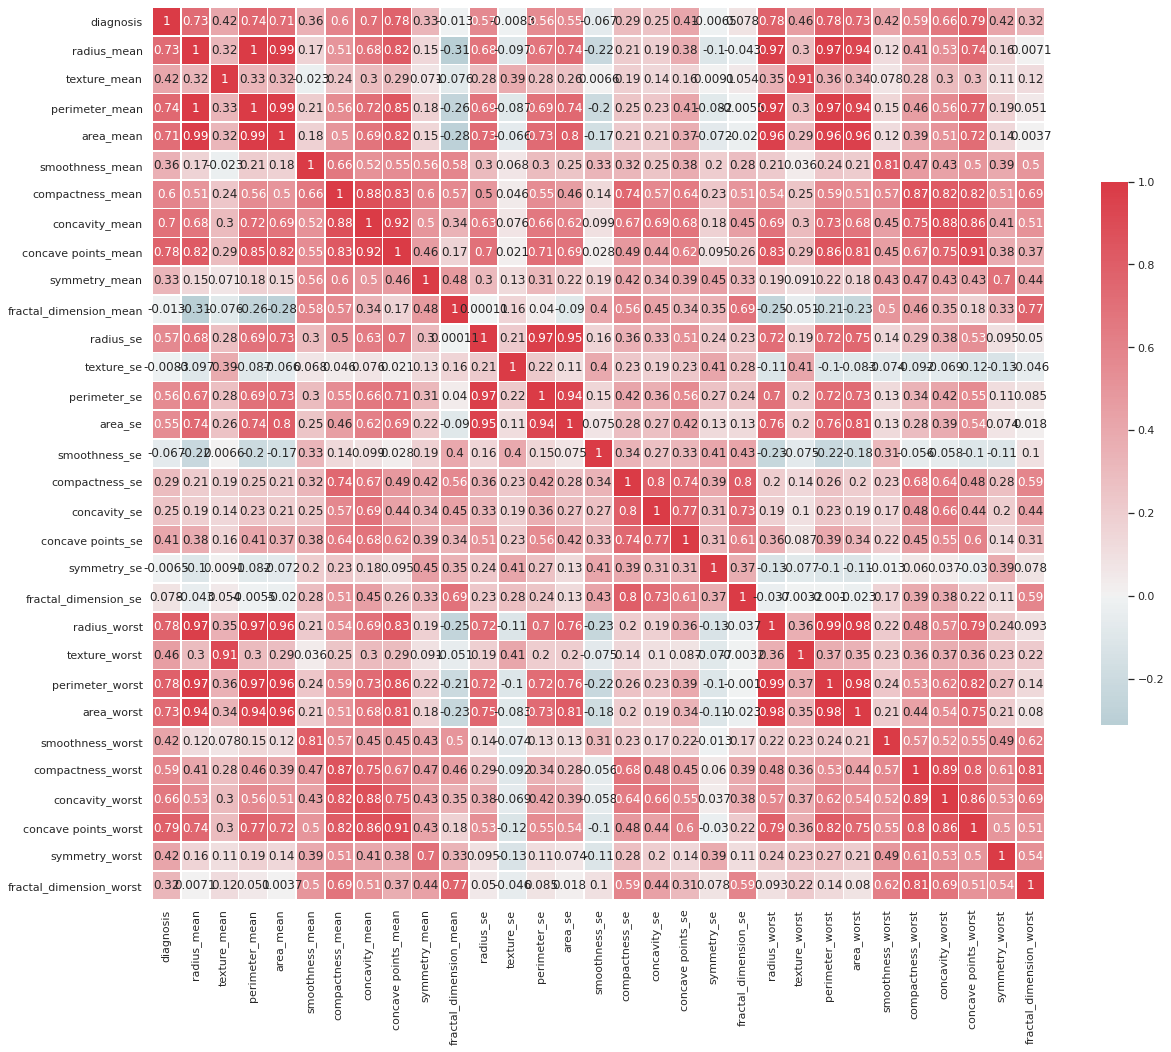

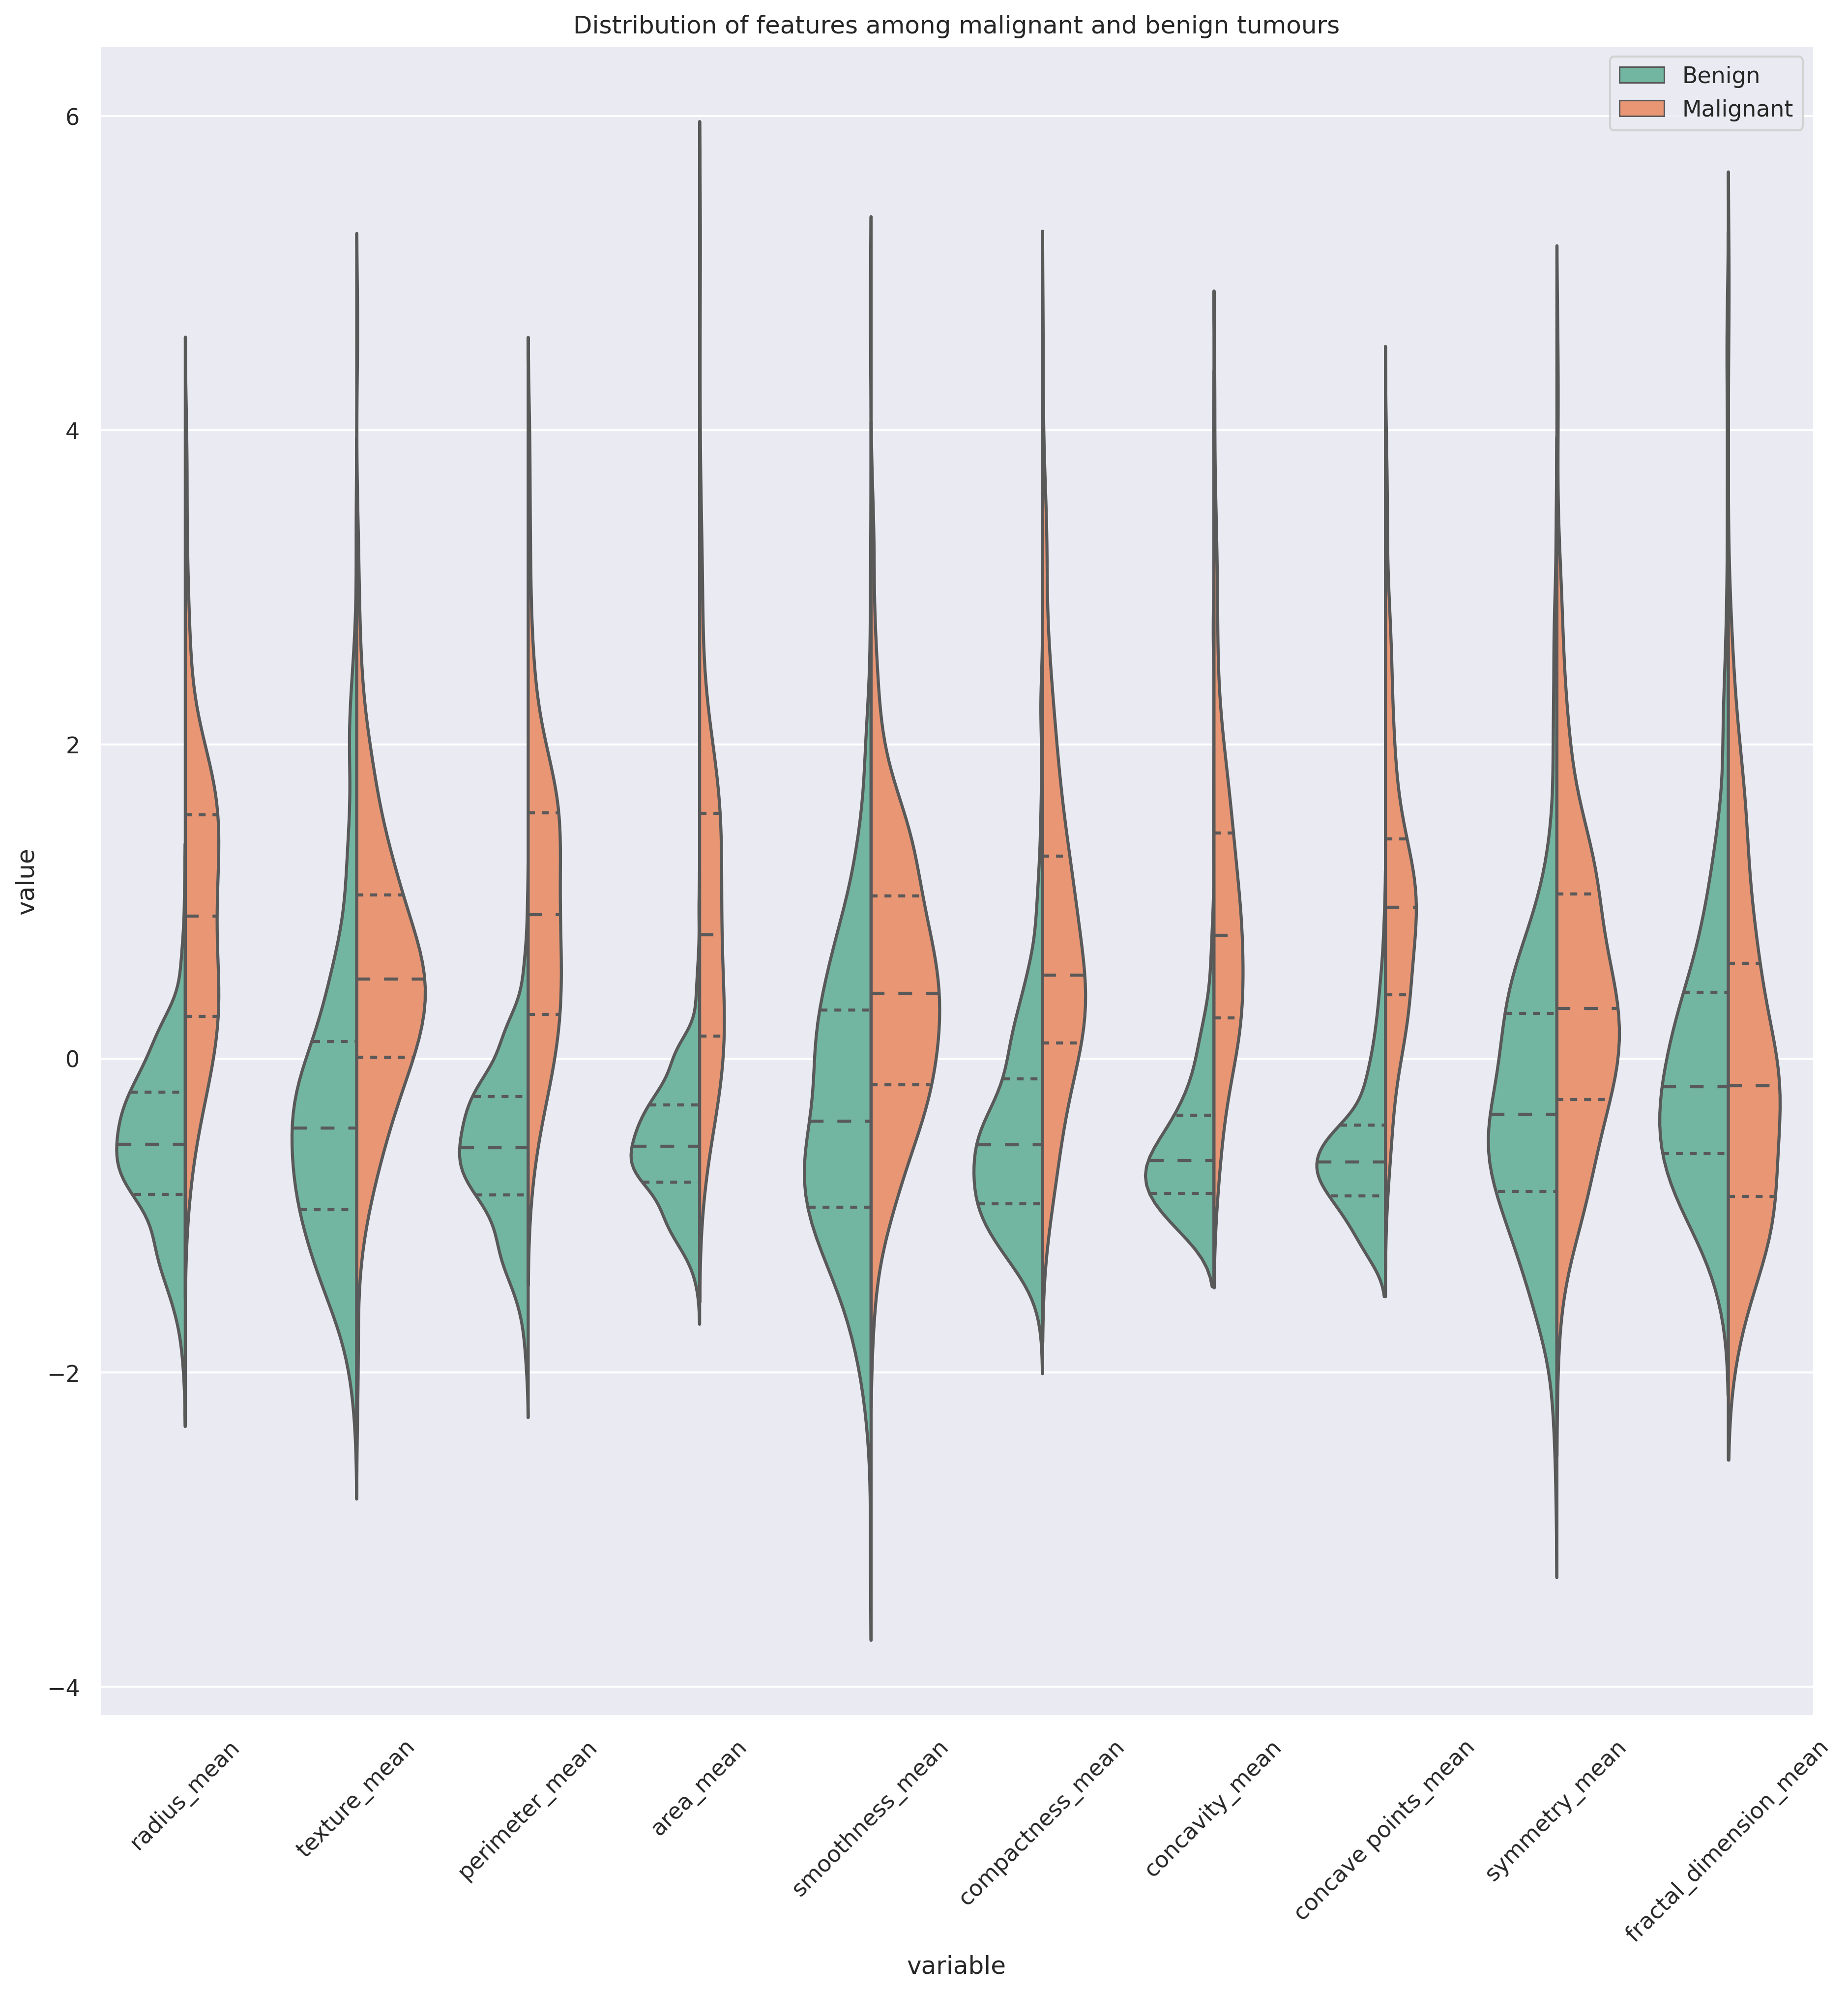

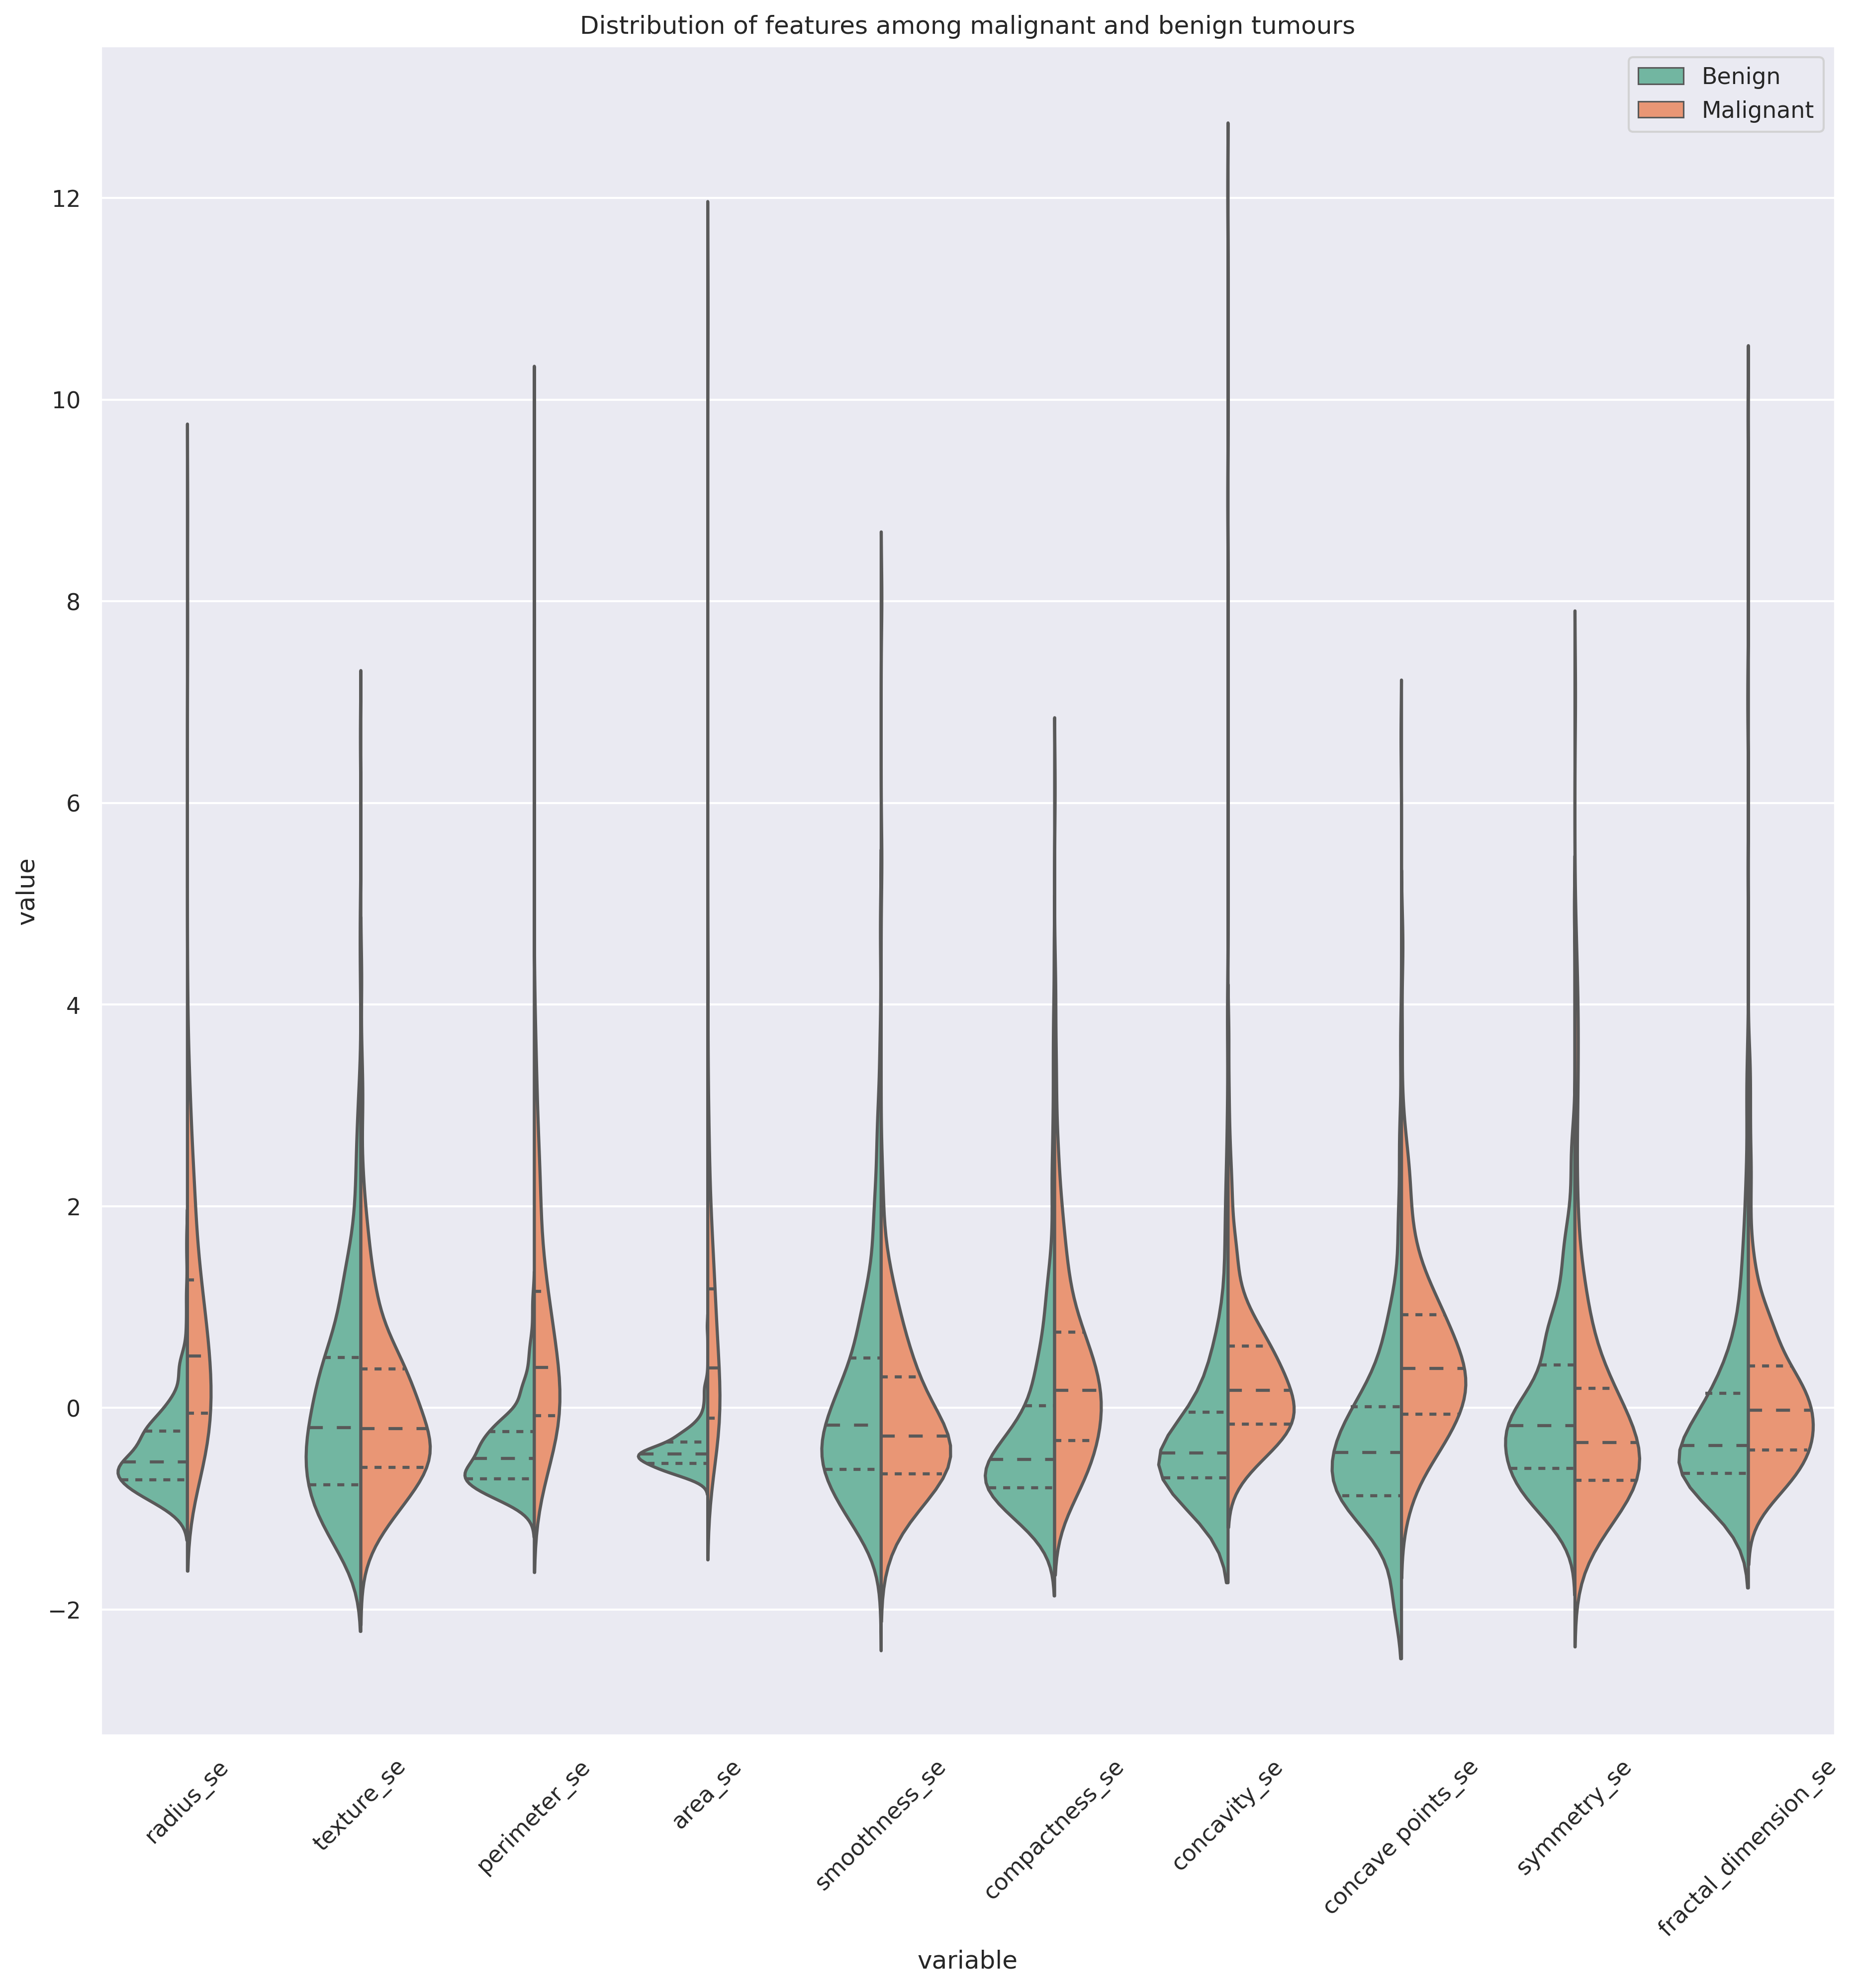

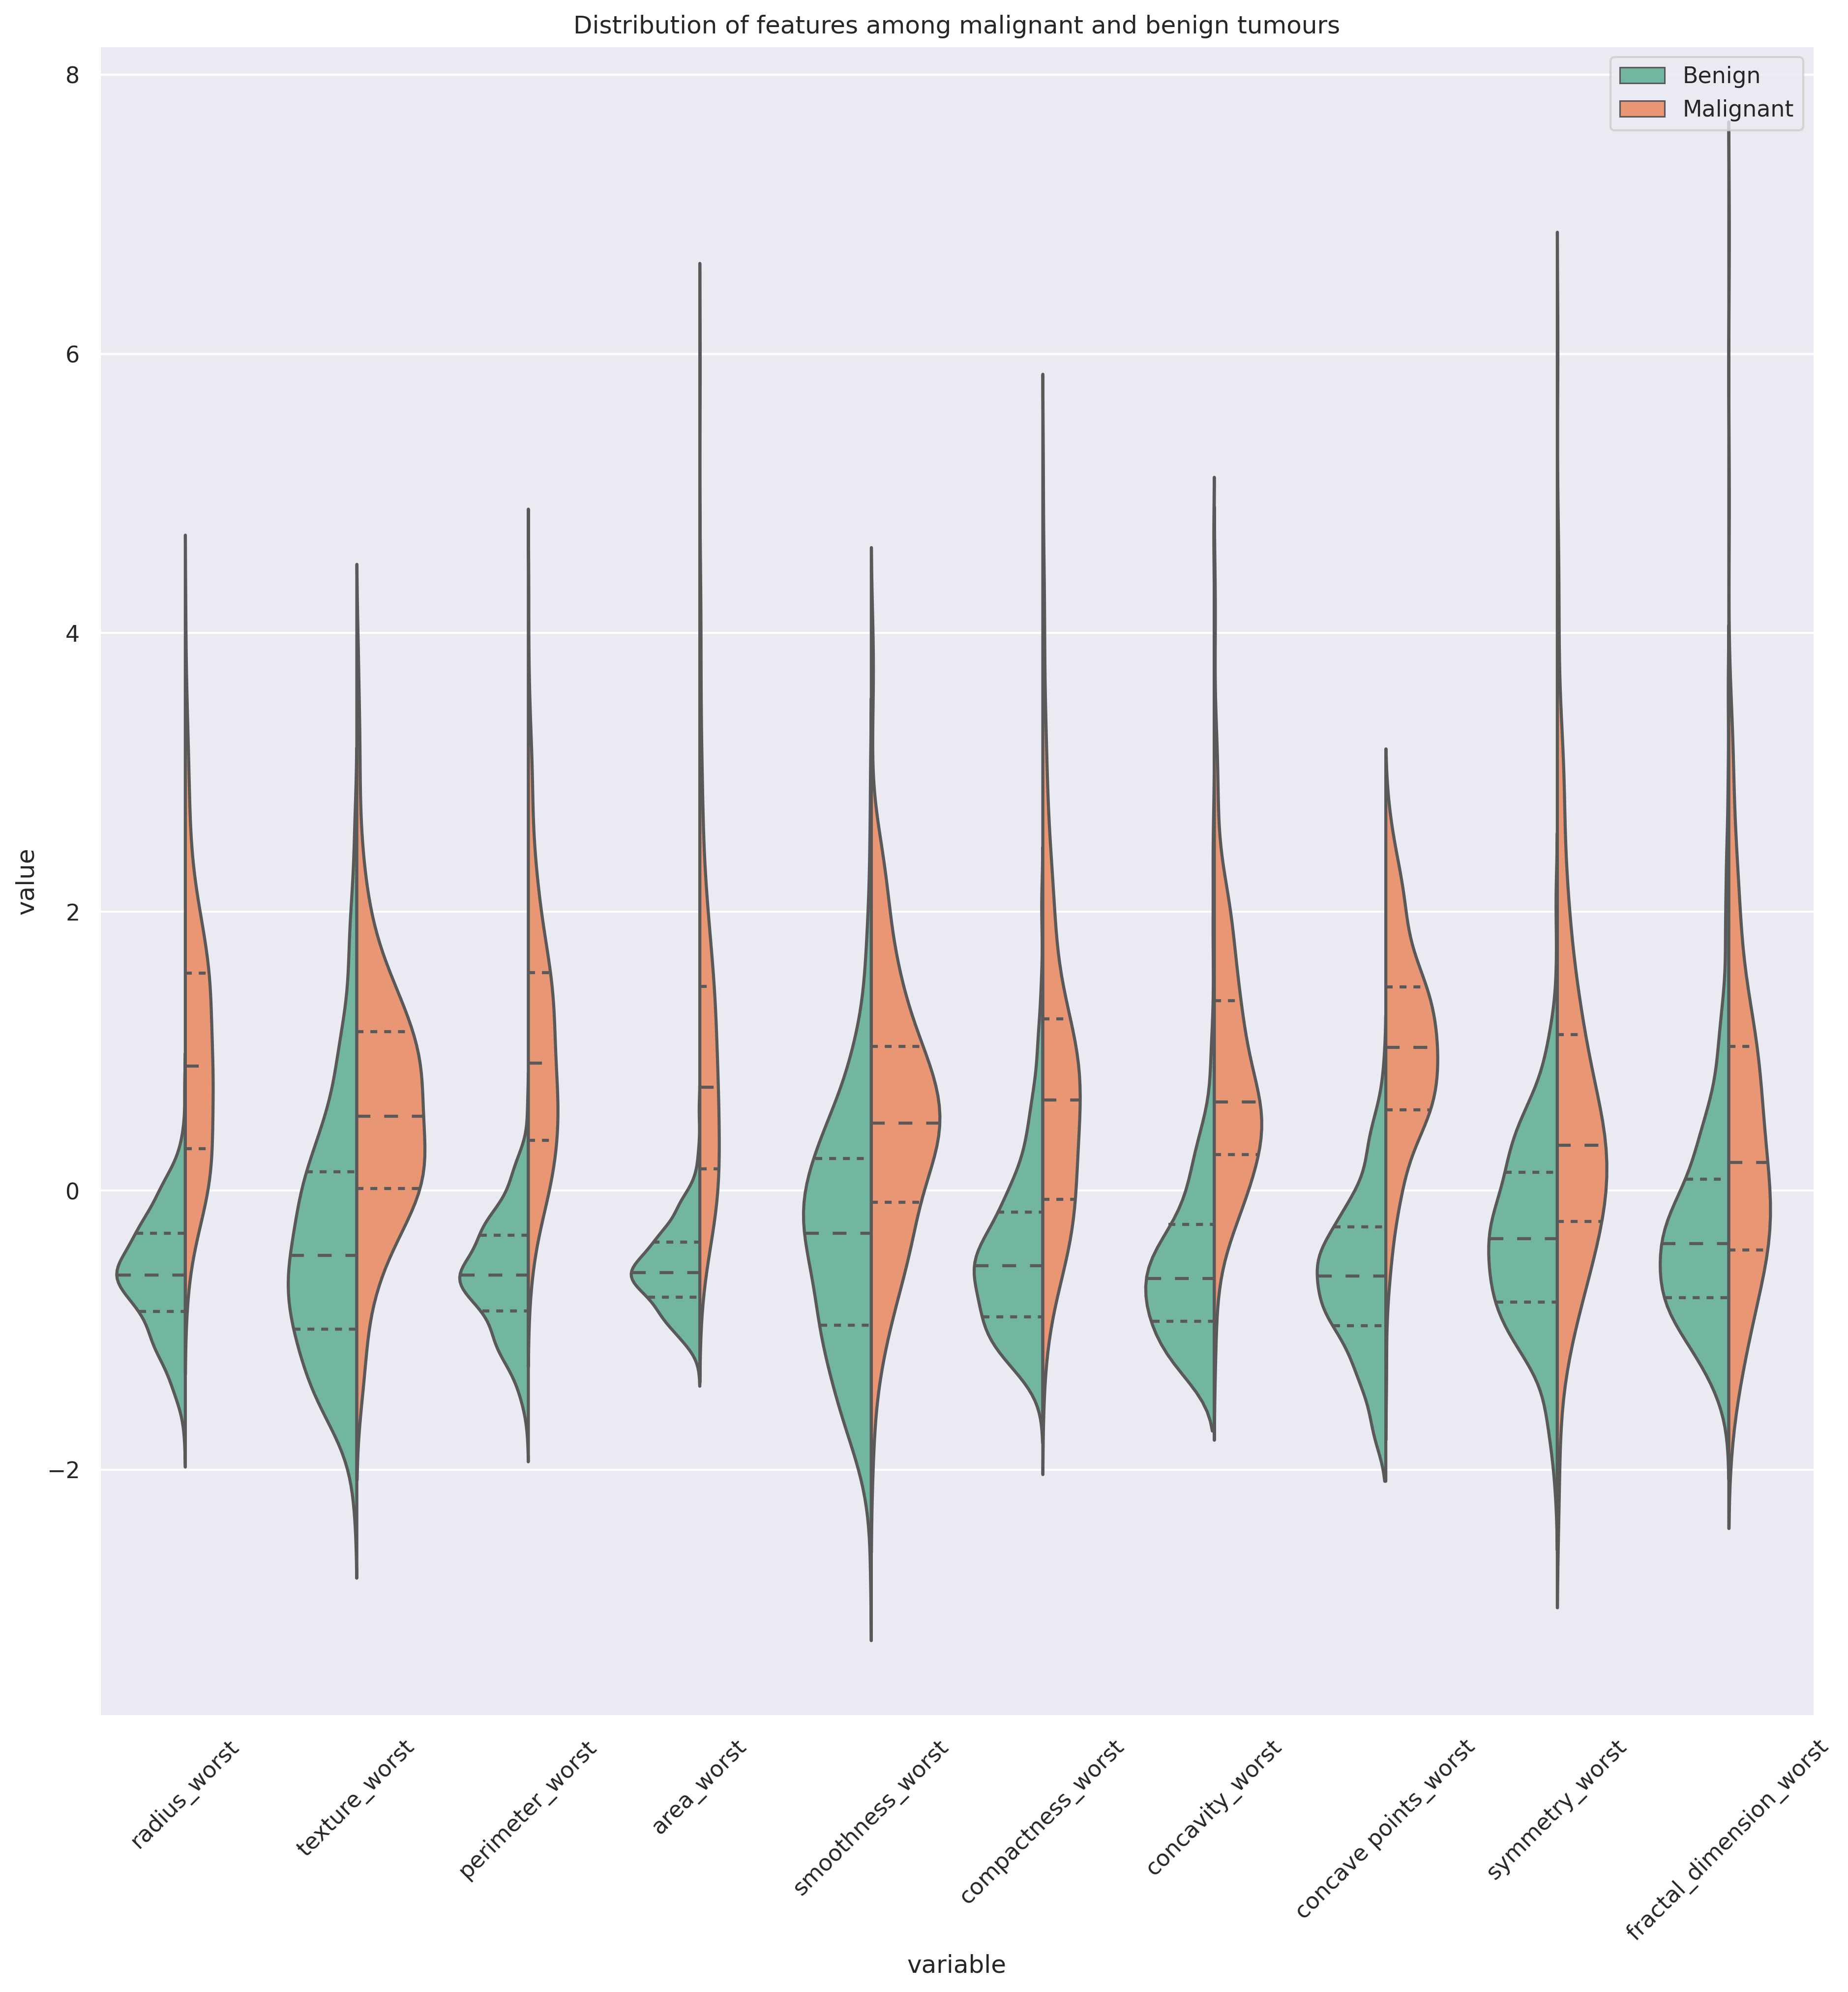

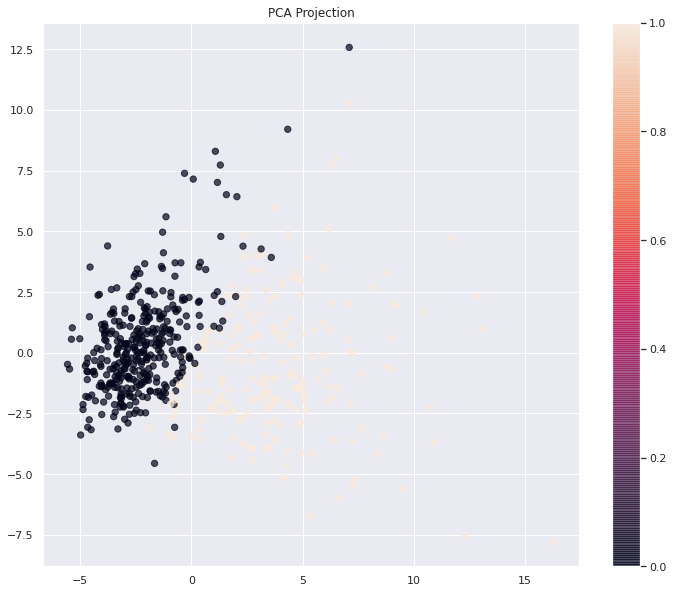

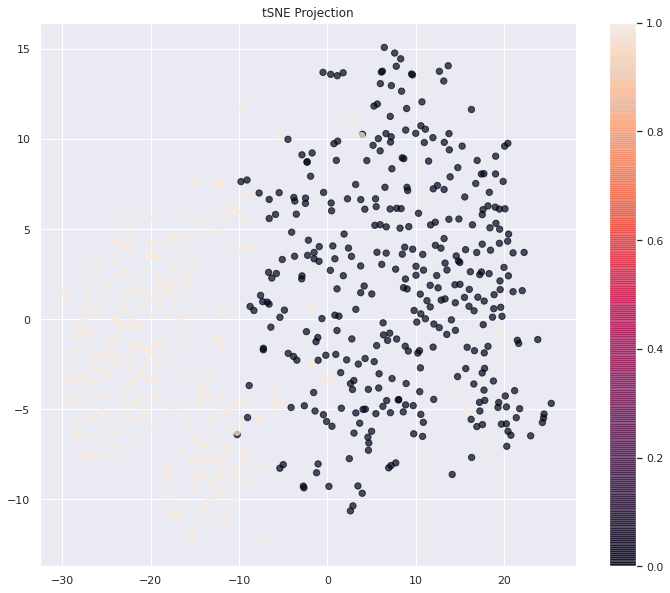

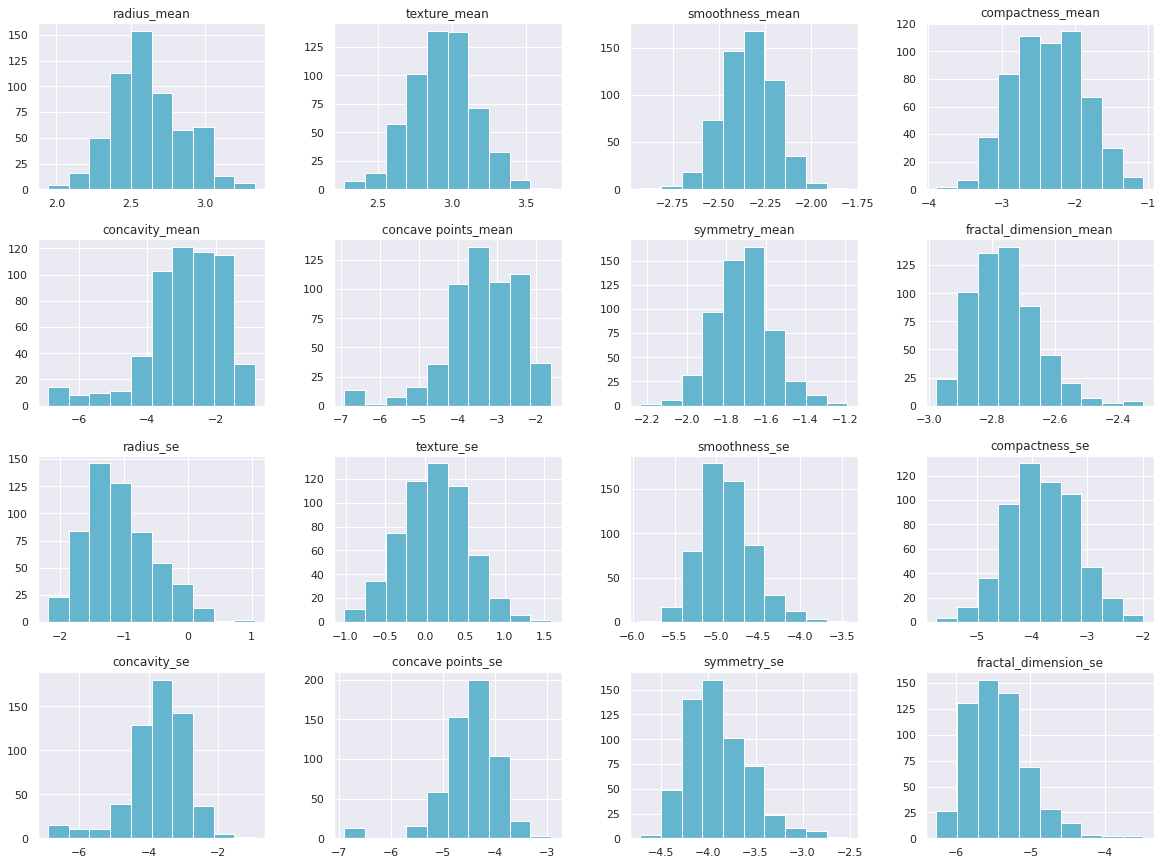

In [49]:
#load libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
sns.set()
from matplotlib import pyplot as plt
from sklearn import decomposition
import warnings
from sklearn.preprocessing import StandardScaler
#Ignore filter warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

#By default, Pandas displays 20 columns and 60 rows, I will increase it to 150 and 100
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 100)

df=pd.read_csv("data.csv",index_col='id')
df.drop('Unnamed: 32',axis=1,inplace=True)
df.head()

df['diagnosis']=df['diagnosis'].map({'M':1,'B':0})
corr=df.corr()
cmap=sns.diverging_palette(220,10,as_cmap=True)
f,ax=plt.subplots(figsize=(20,20))
sns.heatmap(corr,cmap=cmap,center=0,annot=True,square=True,linewidths=0.5,cbar_kws={"shrink":.5})

means=[col for col in df.columns if col.endswith('_mean')]
se=[col for col in df.columns if col.endswith('_se')]
worst=[col for col in df.columns if col.endswith('_worst')]

def plot_violinplot(feat_list):
  scaler=StandardScaler()
  feat_scaled=pd.DataFrame(scaler.fit_transform(df[feat_list]),columns=feat_list,index=df.index)
  data=pd.concat([df['diagnosis'],feat_scaled],axis=1)
  df_melt=pd.melt(frame=data,value_vars=feat_list,id_vars=['diagnosis'])
  fig,ax=plt.subplots(1,1,figsize=(15,15),dpi=300)
  sns.violinplot(x="variable",y="value",hue="diagnosis",
                 data=df_melt,split=True,inner="quart",palette="Set2").set_title('Distribution of features among malignant and benign tumours'.format(feat_list))
  plt.xticks(rotation=45)
  L=plt.legend()
  L.get_texts()[0].set_text('Benign')
  L.get_texts()[1].set_text('Malignant')

plot_violinplot(means)
plot_violinplot(se)
plot_violinplot(worst)

#Apply PCA
X=df.drop('diagnosis',axis=1)
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)
pca=decomposition.PCA(n_components=2)
X_pca_scaled=pca.fit_transform(X_scaled)
print('Projecting %d-dimensional data to 2D' % X_scaled.shape[1])
plt.figure(figsize=(12,10))
plt.scatter(X_pca_scaled[:,0],X_pca_scaled[:,1],c=df['diagnosis'],alpha=0.7,s=40)
plt.colorbar()
plt.title('PCA Projection')
plt.style.use('seaborn-muted')

#Apply TSNE
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2,verbose=1,perplexity=40,n_iter=2000,random_state=17)
df_tsne_scaled=tsne.fit_transform(X_scaled)
plt.figure(figsize=(12,10))
plt.scatter(df_tsne_scaled[:, 0], df_tsne_scaled[:, 1], c=df['diagnosis'], 
            alpha=0.7, s=40)
plt.colorbar()
plt.title('tSNE Projection')

#remove columns
perimeters=[x for x in df.columns if 'perimeter' in x]
areas=[x for x in df.columns if 'area' in x]
df.drop(perimeters,axis=1,inplace=True)
df.drop(areas,axis=1,inplace=True)
worst_x = [col for col in df.columns if col.endswith('_worst')]
df.drop(worst_x,axis=1,inplace=True)

#Normalization
#DecisionTreeClassifier
X=df.drop(['diagnosis'],axis=1)
X_log=np.log(X+0.001)
X_log.hist(figsize=(20,15),color='c')
y=df['diagnosis']
from sklearn.model_selection import train_test_split
X_log_train, X_log_holdout, y_train, y_holdout = train_test_split(X_log, y, test_size=0.3, random_state=17)
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=17)
tree=DecisionTreeClassifier(random_state=17)
tree_params={'max_depth':range(1,5),'max_features':range(3,6),'criterion':['gini','entropy']}
tree_grid=GridSearchCV(tree,tree_params,cv=10,scoring='recall')
tree_grid.fit(X_train,y_train)
tree_grid.best_params_,tree_grid.best_score_

from sklearn.metrics import accuracy_score,recall_score,precision_score
tree_pred=tree_grid.predict(X_holdout)
print("accuracy score tree :",accuracy_score(y_holdout,tree_pred))
print("recall score tree:",recall_score(y_holdout,tree_pred))
print("precision score tree:",precision_score(y_holdout,tree_pred))
#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_holdout,tree_pred)

#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
#Stratified split for the validation process
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17)
#initialize the set of parameters for exhaustive search and fit to find out the optimal parameters
rfc = RandomForestClassifier(n_estimators=100, criterion ='gini', max_depth = 8, max_features = 6, min_samples_leaf = 1, random_state = 17, n_jobs=-1)
rfc.fit(X_train,y_train)
forest_pred = rfc.predict(X_holdout)
print ("Accuracy Score rfc: ",accuracy_score(y_holdout, forest_pred) )
print ("Recall Score rfc : ",recall_score(y_holdout, forest_pred))
print ("Precision Score rfc: ",precision_score(y_holdout, forest_pred))

#KNN
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=10)
knn.fit(X_scaled,y)
knn_params={'n_neighbors':range(1,11),'weights':['uniform','distance']}
X_scaled_train,X_scaled_holdout,y_train,y_holdout=train_test_split(X_scaled,y,test_size=0.3,random_state=17)
knn_grid=GridSearchCV(knn,knn_params,cv=10,n_jobs=-1,scoring='recall')
knn_grid.fit(X_scaled_train,y_train)
knn_grid.best_params_,knn_grid.best_score_
pred=knn_grid.best_estimator_.predict(X_scaled_holdout)
print ("Accuracy Score KNN: ",accuracy_score(y_holdout, pred))
print ("Recall Score KNN: ",recall_score(y_holdout, pred) )
print ("Precision Score KNN: ",precision_score(y_holdout, pred))

